## Step 0.1: Install libraries required for the scriopt

As stated in the title of the step, this is to install the needed libraries for the script to finish(pandas, numpy, sklearn etc...). Take not that you need to have "requirements.txt" in the same folder as this python notebook


In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Step 0.2: Importing needed prerequisites from installed libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
import re

import seaborn as sns
from scipy.stats import spearmanr
import statsmodels.formula.api as smf

import io
import requests

from zipfile import ZipFile
from io import BytesIO

## Step 1: Parsing and preprocessing of PSA Poverty Dataset

The poverty dataset is an xlsx file promptly named by the PSA as "Preliminary 2023 1st sem Poverty Statistics Tables.xlsx", this file format is universal to all datasets used in this script(Other than the final dataset from the worldbank). 

The dataset contains many sheets but we primarily use the sheet named "tab2" as it includes the **Per Capita Poverty Threshold** among populations, following the needed sample of the population for the needed demographic for this study. Fortunately, the PSA has also included the entirety of the Philippines as its first row, making it easier to parse on our end.

We note however, that the dataset contains many inconsistencies(this will be very prevalent in the other PSA datasets used for this script). The years included in the dataset were only from 2018, 2021, and 2023 only. This causes us to augment the original data with recommended strategies common to time-series dataset. This will be explained more clearly in the next few steps. 

Additionally, instead of fragmented code cells of the same step, we will also explain parts of the code through comments instead of markdown cells. This will greatly aid in consistency, flow, and explanation of the script.

In [3]:
# --------------------------------------------------------------
# 1. POVERTY TIME-SERIES – PHILIPPINES (FIRST SEMESTER ONLY)
# --------------------------------------------------------------

# ------------------------------------------------------------------
# 1.1 Load the Excel file
# - Loading the excel file and storing it in a dataframe
# ------------------------------------------------------------------
pov_file = 'Preliminary 2023 1st sem Poverty Statistics Tables.xlsx'
df_raw   = pd.read_excel(pov_file, sheet_name='tab2', header=None)

print("\n--- Raw head (first 12 rows) ---")
display(df_raw.head(12))

# ------------------------------------------------------------------
# 1.2 Keep only the 7 columns we need (Region + 3×Threshold + 3×Incidence)
# - It's extremely hard to parse multiple layers of categorized columns so we just pick the fixed positions of the columns we need.
# - We then label the columsns of the dataframe accordingly.
# ------------------------------------------------------------------
cols_needed = [0, 1, 2, 3, 4, 5, 6]               # fixed positions
df_data     = df_raw.iloc[7:, cols_needed].copy().reset_index(drop=True)

df_data.columns = [
    'Region',
    'Threshold_2018', 'Threshold_2021', 'Threshold_2023p',
    'Incidence_2018', 'Incidence_2021', 'Incidence_2023p'
]

print("\n--- Cleaned DataFrame (first 10 rows) ---")
display(df_data.head(10))

# ------------------------------------------------------------------
# 1.3 Extract the PHILIPPINES row
# - The dataset(sheet "tab2") only contains one row that corresponds to the entire Philippines. So we can filter the needed row via string matching.
# - Once the needed row is located, we drop all other rows and reset the index.
# ------------------------------------------------------------------
mask_ph = df_data['Region'].astype(str).str.contains('philippines', case=False, na=False)
df_ph   = df_data.loc[mask_ph].copy().reset_index(drop=True)

print("\n--- PHILIPPINES row ---")
display(df_ph)

# ------------------------------------------------------------------
# 1.4 Melt → long format (Year, Threshold, Incidence)
# - Once the row is extracted, we melt the dataframe to long format for easier analysis.
# ------------------------------------------------------------------
# ---- Threshold ----
df_thresh = df_ph.melt(
    id_vars=[],
    value_vars=['Threshold_2018', 'Threshold_2021', 'Threshold_2023p'],
    var_name='Var',
    value_name='Threshold_PhP'
)
df_thresh['Year'] = df_thresh['Var'].str.extract(r'(\d{4}p?)')[0].str.replace('p', '').astype(int)

# ---- Incidence ----
df_inc = df_ph.melt(
    id_vars=[],
    value_vars=['Incidence_2018', 'Incidence_2021', 'Incidence_2023p'],
    var_name='Var',
    value_name='Incidence_%'
)
df_inc['Year'] = df_inc['Var'].str.extract(r'(\d{4}p?)')[0].str.replace('p', '').astype(int)

# ---- Merge ----
df_final = pd.merge(
    df_thresh[['Year', 'Threshold_PhP']],
    df_inc[['Year', 'Incidence_%']],
    on='Year'
).sort_values('Year').reset_index(drop=True)

# ------------------------------------------------------------------
# 1.5 Clean dtypes & rounding (safe – coerce to numeric first)
# - Ensuring that the final dataframe has the correct data types for analysis.
# ------------------------------------------------------------------
df_final['Threshold_PhP'] = pd.to_numeric(df_final['Threshold_PhP'], errors='coerce')
df_final['Incidence_%']   = pd.to_numeric(df_final['Incidence_%'],   errors='coerce')

df_final['Threshold_PhP'] = df_final['Threshold_PhP'].astype(int)
df_final['Incidence_%']   = df_final['Incidence_%'].round(1)

print("\n--- FINAL POVERTY TIME-SERIES (PHILIPPINES, FIRST SEMESTER) ---")
display(df_final)

# ------------------------------------------------------------------
# 1.6 Save
# - Save the final cleaned dataframe to a CSV file for future analysis. (or for quick access)
# ------------------------------------------------------------------
df_final.to_csv('poverty_time_series_first_semester.csv', index=False)
print("\nSaved: 'poverty_time_series_first_semester.csv'")

c:\Users\Admin\Documents\Visual Studio Code\cs-132-WFR-Group4\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
c:\Users\Admin\Documents\Visual Studio Code\cs-132-WFR-Group4\.venv\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)



--- Raw head (first 12 rows) ---


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Table 2. First Semester Per Capita Poverty Th...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Region/Province,First Semester Per Capita Poverty Threshold \n...,NaN,NaN,Frist Semester Poverty Incidence among Population,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,Estimate (%),NaN,NaN,Coefficient of Variation,NaN,NaN,...,NaN,NaN,90% Confidence Interval,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,2018,2021.00,2023p,2018,2021.00,2023p,2018,2021.00,2023p,...,2021.00,2023p,2018,NaN,2021,NaN,2023p,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Lower Limit,Upper Limit,Lower Limit,Upper Limit,Lower Limit,Upper Limit,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,"PHILIPPINES 1/, 2/",12637.92,14498.08,16556.98,21.05,23.72,22.36,1.07,1.07,1.86,...,0.25,0.42,20.68,21.42,23.3,24.14,21.67,23.04,23.30,24.14
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"National Capital Region (NCR) 1/, 2/",14102.11,16625.05,18703.79,6.58,7.81,5.06,5.61,4.46,6.24,...,0.35,0.32,5.98,7.19,7.24,8.39,4.54,5.58,7.24,8.39



--- Cleaned DataFrame (first 10 rows) ---


,Region,Threshold_2018,Threshold_2021,Threshold_2023p,Incidence_2018,Incidence_2021,Incidence_2023p
0,"PHILIPPINES 1/, 2/",12637.92,14498.08,16556.98,21.05,23.72,22.36
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"National Capital Region (NCR) 1/, 2/",14102.11,16625.05,18703.79,6.58,7.81,5.06
3,"1st District 1/, a/, b/",14102.11,16625.05,18703.79,7.5,3.49,5.38
4,2nd District 2/,14102.11,16625.05,18703.79,4.98,6.22,3.88
5,3rd District 2/,14102.11,16625.05,18703.79,10.13,11.26,7.2
6,"4th District 1/, 2/",14102.11,16625.05,18703.79,5.49,9.29,4.83
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Cordillera Administrative Region (CAR) 2/,12357.67,14022.61,15912.23,17.89,16.21,13.88
9,Abra 1/,12406.34,14320.57,16656.05,34.46,28.09,26.89



--- PHILIPPINES row ---


,Region,Threshold_2018,Threshold_2021,Threshold_2023p,Incidence_2018,Incidence_2021,Incidence_2023p
0,"PHILIPPINES 1/, 2/",12637.92,14498.08,16556.98,21.05,23.72,22.36



--- FINAL POVERTY TIME-SERIES (PHILIPPINES, FIRST SEMESTER) ---


,Year,Threshold_PhP,Incidence_%
0,2018,12637,21.0
1,2021,14498,23.7
2,2023,16556,22.4



Saved: 'poverty_time_series_first_semester.csv'


As we can see above, after cleaning and pre-processing the first dataset, we're only able to obtain three rows of results regarding the Poverty threshold and Poverty Incidence from PSA for the past few years. Moreover, they were inconcistent with their data collection(No Patterns in the data collected im terms of when they collected their data. Also, they didn't annually acquire their data). Though at the very least we can see that there's an increasing trend for both the Poverty Threshold and the Poverty Incidence.

## Step 2: Parsing and preprocessing of GDP Dataset, and start of Data Augmentation

The GDP dataset is an xlsx file promptly named by the PSA as "GRDP_Reg_2018PSNA_2022_to_2024_with_NIR.xlsx", as stated earlier it follows the format that PSA uses excel files to store their data(or when sharing it to the public)

We use the sheet **Capita**,, as it measures GDP per population, matching the required sample description that we need for the project. Again, it contains three rows for Philippines but the years for the data were 2022, 2023, and 2024. Additionally, the formatting of their data was odd. Yes, it can be said that it is ordered, but each sheet has multiple tables that more or less describes the same variable but with different sample descriptions. This made extracting the needed data a bit more challenging, otherwise, the lack of relevant data(for some reason, the data only has three years recorded) after pre-processing can still be observed in this data.

Due to the reasons above, this is where we start augmenting the data by merging tables of previous results, then applying data science techniques in an attempt to obtain significant results

In [4]:
# --------------------------------------------------------------
# 2. LOAD & MERGE GDP PER CAPITA (2022–2024) – FULL OUTER MERGE
# --------------------------------------------------------------

# ------------------------------------------------------------------
# 2.1 Load poverty data (from Step 1)
# - Loading the csv file from the previous code cell
# ------------------------------------------------------------------
df_pov = pd.read_csv('poverty_time_series_first_semester.csv')

print("\n--- Poverty Time-Series (First Semester) ---")
display(df_pov)

# ------------------------------------------------------------------
# 2.2 Load 'capita' sheet
# - Accessing the sheet only named "capita" and storing it in a dataframe
# ------------------------------------------------------------------
gdp_file = 'GRDP_Reg_2018PSNA_2022_to_2024_with_NIR.xlsx'
df_gdp_raw = pd.read_excel(gdp_file, sheet_name='Capita', header=None)

# ------------------------------------------------------------------
# 2.3 Find the Philippines row (at the bottom)
#  - Extracting the row that contains GDP per capita data for the Philippines, for the furst table "Per Capita GRDP"
# ------------------------------------------------------------------
mask_ph = df_gdp_raw.iloc[:, 1].astype(str).str.contains('Philippines', case=False, na=False)
ph_row_idx = df_gdp_raw[mask_ph].index[0]

print(f"\nPhilippines row found at index: {ph_row_idx}")

# ------------------------------------------------------------------
# 2.4 Extract GDP per capita values
# - Once the Philippines row is located, we extract the GDP per capita values for 2022, 2023, and 2024.
# ------------------------------------------------------------------
gdp_2022 = pd.to_numeric(df_gdp_raw.iloc[ph_row_idx, 2], errors='coerce')
gdp_2023 = pd.to_numeric(df_gdp_raw.iloc[ph_row_idx, 3], errors='coerce')
gdp_2024 = pd.to_numeric(df_gdp_raw.iloc[ph_row_idx, 4], errors='coerce')

df_gdp = pd.DataFrame([
    {'Year': 2022, 'GDP_per_Capita_PhP': gdp_2022},
    {'Year': 2023, 'GDP_per_Capita_PhP': gdp_2023},
    {'Year': 2024, 'GDP_per_Capita_PhP': gdp_2024}
])

print("\n--- Extracted GDP per Capita (Philippines) ---")
display(df_gdp)

# ------------------------------------------------------------------
# 2.5 FULL OUTER MERGE → Keep all years, fill missing with NaN
# - Merging the poverty data with the GDP per capita data using a full outer join to ensure all years are preserved.
# ------------------------------------------------------------------
df_merged = pd.merge(df_pov, df_gdp, on='Year', how='outer')

# Sort by Year
df_merged = df_merged.sort_values('Year').reset_index(drop=True)

# Reorder columns
df_merged = df_merged[['Year', 'Threshold_PhP', 'Incidence_%', 'GDP_per_Capita_PhP']]

print("\n--- FINAL MERGED DATASET (FULL OUTER – ALL YEARS PRESERVED) ---")
display(df_merged)

# ------------------------------------------------------------------
# 2.6 Save full merged dataset
# - Save the final cleaned dataframe to a CSV file for future analysis.
# ------------------------------------------------------------------
df_merged.to_csv('poverty_gdp_merged_full.csv', index=False)
print("\nSaved: 'poverty_gdp_merged_full.csv'")



--- Poverty Time-Series (First Semester) ---


,Year,Threshold_PhP,Incidence_%
0,2018,12637,21.0
1,2021,14498,23.7
2,2023,16556,22.4



Philippines row found at index: 30

--- Extracted GDP per Capita (Philippines) ---


,Year,GDP_per_Capita_PhP
0,2022,198560.540114
1,2023,217255.238529
2,2024,234277.456949



--- FINAL MERGED DATASET (FULL OUTER – ALL YEARS PRESERVED) ---


,Year,Threshold_PhP,Incidence_%,GDP_per_Capita_PhP
0,2018,12637.0,21.0,NaN
1,2021,14498.0,23.7,NaN
2,2022,NaN,NaN,198560.540114
3,2023,16556.0,22.4,217255.238529
4,2024,NaN,NaN,234277.456949



Saved: 'poverty_gdp_merged_full.csv'


As seen with the results above, we merged the three obtained values of GDP to the first table we processed(which is the Poverty Dataset). Due to the outer merged, we obtained NaN's in years that don't have any recoreded data for the needed variables(columns). We will attempt to **fix** this later after we have merged everything we need for the first primary table.

The results when merging the previous two datasets show that there is almost twice the amount of observed post-processed results. Yet, this is **still** not enough for our standards(again our goal is 100). Similar to our decision in the previoous finalized dataset, we'll hold this off for now as a backup plan.

## Step 3: Parsing and preprocessing of Employed and Underemployed(By Thousands and Rate%) Dataset, and start of Data Augmentation

The employed dataset is an xlsx file promptly named by the PSA as "Table 2. Total Employed Persons and Employment Rate_2023f and 2024p.xlsx", while the underemployed dataset is named "Table 4. Total Underemployed Persons and Underemployment Rate_2023f and 2024p_1.xlsx".

Both datasets more or less describes the same sample description we need for this study, however they still are lacking in terms of the number of observations we need(Our goal is at least 100 observation post-processing, but the datasets provided by PSA make this almost impossible sadly). Though the formatting of this dataset was rather cleaner compared to the previous(GDP) one. 

Again, we merge this with previous results to increase our final observations post-processing. However this time, we've already obtained the needed variables in order to compute for correlations. So in this step, we attempt to supplement the NaNs with backward and forward filling as it is adviced to do this method when dealing with time series data.

In [5]:
# --------------------------------------------------------------
# 3. MERGE + GLOBAL FILL → 100 % NaN-FREE PANEL
# --------------------------------------------------------------



# --------------------------------------------------------------
# 3.1 Load long panel
#  - Loading the csv file from the previous code cell
# --------------------------------------------------------------
df = pd.read_csv('poverty_gdp_merged_full.csv')

# --------------------------------------------------------------
# 3.2 Helper – Philippines row
#  - Helper function to extract the Philippines row from given Excel files(The two datasets used in this step have the same format)
# --------------------------------------------------------------
def ph_row(file, sheet, skip=3):
    raw = pd.read_excel(file, sheet_name=sheet, skiprows=skip)
    raw.columns = [c.replace('\n', ' ').strip() for c in raw.columns]
    return raw.iloc[0]

# --------------------------------------------------------------
# 3.3 Employed (Table 2)
# - Extracting employed data for 2023 and 2024 from the specified Excel file
# --------------------------------------------------------------
emp = ph_row('Table 2. Total Employed Persons and Employment Rate_2023f and 2024p.xlsx',
             'Table 2')
df_emp = pd.DataFrame([
    {'Year': 2023,
     'Employed_Thousands': emp["Estimate ('000)"],
     'Employment_Rate_%': emp["Estimate (%)"]},
    {'Year': 2024,
     'Employed_Thousands': emp["Estimate ('000).1"],
     'Employment_Rate_%': emp["Estimate (%).1"]},
])

# --------------------------------------------------------------
# 3.4 Underemployed (Table 4)
# - Extracting underemployed data for 2023 and 2024 from the specified Excel file
# --------------------------------------------------------------
und = ph_row('Table 4. Total Underemployed Persons and Underemployment Rate_2023f and 2024p_1.xlsx',
             'Table 4')
df_und = pd.DataFrame([
    {'Year': 2023,
     'Underemployed_Thousands': und["Estimate ('000)"],
     'Underemployment_Rate_%': und["Estimate (%)"]},
    {'Year': 2024,
     'Underemployed_Thousands': und["Estimate ('000).1"],
     'Underemployment_Rate_%': und["Estimate (%).1"]},
])

# --------------------------------------------------------------
# 3.4 Outer Merge (keep every historical year)
# --------------------------------------------------------------
df = df.merge(df_emp, on='Year', how='outer')
df = df.merge(df_und, on='Year', how='outer')

# --------------------------------------------------------------
# 3.6 GLOBAL forward + backward fill (all numeric columns)
# - To remove NaN values, we apply forward fill followed by backward fill on all numeric columns. (And Avoid inroducing bias by using mean/median)
# --------------------------------------------------------------
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].ffill().bfill()

# --------------------------------------------------------------
# 3.7 Final tidy
# - Cleaning and reordering the final dataframe for presentation.
# --------------------------------------------------------------
df = df.sort_values('Year').reset_index(drop=True)
df = df[[
    'Year', 'Threshold_PhP', 'Incidence_%', 'GDP_per_Capita_PhP',
    'Employed_Thousands', 'Employment_Rate_%',
    'Underemployed_Thousands', 'Underemployment_Rate_%'
]]

# --------------------------------------------------------------
# 3.8 Save & show
# - Save to CSV 
# --------------------------------------------------------------
df.to_csv('full_merged_dataset.csv', index=False)
print("NaN-FREE dataset ready: full_merged_dataset.csv")
display(df.head(10))

NaN-FREE dataset ready: full_merged_dataset.csv


,Year,Threshold_PhP,Incidence_%,GDP_per_Capita_PhP,Employed_Thousands,Employment_Rate_%,Underemployed_Thousands,Underemployment_Rate_%
0,2018,12637.0,21.0,198560.540114,48177.763,95.646,5943.946,12.338
1,2021,14498.0,23.7,198560.540114,48177.763,95.646,5943.946,12.338
2,2022,14498.0,23.7,198560.540114,48177.763,95.646,5943.946,12.338
3,2023,16556.0,22.4,217255.238529,48177.763,95.646,5943.946,12.338
4,2024,16556.0,22.4,234277.456949,48842.754,96.174,5818.422,11.913


As can be observed with the results for the step above, there are no more NaNs in the data, which allows us to continue with obtaining statistical data. However, one thing is preventing us to do so, the lack of post-processed observation. Even wiith our efforts for augmenting data, we only managed to obtain 5 proper rows of observations. So sadly, we have to hold this off for now and only use it if we really have nothing else to use.

## Step 4: Creation of new dataframe for Employed, Unemployed, and Underemployed

To keep things brief, starting this markdown cell, we'll only describe the most needed and significant details for each step. The dataset used for this step is the employed dataset named "TABLE 1   Employed Persons by Sector, Occupation, and Class of Worker, with Measures of Precision, Philippines_Aug2025.xlsx", and the underemployed dataset named "TABLE 3   Underemployed Persons by Hours Worked and Sector, and Unemployed Persons by Age Group, Sex, and Highest Grade Completed_Aug2025.xlsx". It has more pre-processed observations, this led us to have more hope that it can be used for statistical results. The dataset only contains data from 2024 to 2025, but it it is more in-depth, as it has months for these observations.

In [6]:
# --------------------------------------------------------------
# 4. PARSE & MERGE TABLE 1 (EMPLOYED) & TABLE 3 (UNDEREMPLOYED/UNEMPLOYED)
# --------------------------------------------------------------
# Explanation:
# - Parses TABLE 1 for monthly employed numbers (thousands)
# - Parses TABLE 3 for monthly underemployed and unemployed numbers (thousands)
# - Computes rates: Employment Rate (%) = Employed / (Employed + Unemployed) * 100
# - Underemployment Rate (%) = Underemployed / Employed * 100
# - Maps periods to Year-Month (e.g., 'August 2024f' → '2024-08')
# - Creates separate DF for labor metrics (monthly, 2024-08 to 2025-08)
# - Saves 'labor_time_series.csv' for correlation with CPI later
# - Granular: Separate extraction for TABLE 1 & 3, then merge
# - Optimized: Direct indexing for key rows (EMPLOYED PERSONS, UNDEREMPLOYED PERSONS, UNEMPLOYED PERSONS)
# - No errors: Handles floats, NaN safely

# ------------------------------------------------------------------
# 4.1 Parse TABLE 1 – Employed Persons (monthly)
# - Parsing the employed persons data from TABLE 1 Excel file
# - Includes measures of precision, but we only extract the estimates
# - Maps periods to Year-Month format
# ------------------------------------------------------------------
table1_file = 'TABLE 1   Employed Persons by Sector, Occupation, and Class of Worker, with Measures of Precision, Philippines_Aug2025.xlsx'
df_table1 = pd.read_excel(table1_file, sheet_name='Table 1', skiprows=4, header=0)

# Clean column names (remove extra spaces)
df_table1.columns = [col.strip() for col in df_table1.columns]

print("\n--- Raw TABLE 1 (first 15 rows) ---")
display(df_table1.head(15))

# Extract employed row (row with 'EMPLOYED PERSONS')
mask_employed = df_table1.iloc[:, 0].astype(str).str.contains('EMPLOYED PERSONS', case=False, na=False)
employed_row = df_table1.loc[mask_employed].copy().reset_index(drop=True).iloc[0]

# Periods (columns 1,3,5,... for Estimates)
periods = [
    'August 2024f', 'January 2025p', 'February 2025p', 'March 2025p',
    'April 2025p', 'May 2025p', 'June 2025p', 'July 2025p', 'August 2025p'
]

# Employed thousands (Estimate columns: 1,3,5,...)
employed_values = [employed_row[1], employed_row[3], employed_row[5], employed_row[7], employed_row[9], employed_row[11], employed_row[13], employed_row[15], employed_row[17]]

df_employed = pd.DataFrame({
    'Period': periods,
    'Employed_Thousands': employed_values
})

# Map to Year-Month
month_map = {
    'August 2024f': '2024-08', 'January 2025p': '2025-01', 'February 2025p': '2025-02',
    'March 2025p': '2025-03', 'April 2025p': '2025-04', 'May 2025p': '2025-05',
    'June 2025p': '2025-06', 'July 2025p': '2025-07', 'August 2025p': '2025-08'
}
df_employed['Year_Month'] = df_employed['Period'].map(month_map)
df_employed['Year'] = df_employed['Year_Month'].str[:4].astype(int)
df_employed['Month'] = df_employed['Year_Month'].str[5:7].astype(int)

print("\n--- Employed Monthly Data ---")
display(df_employed)

# ------------------------------------------------------------------
# 4.2 Parse TABLE 3 – Underemployed & Unemployed (monthly)
# - Parsing the underemployed and unemployed persons data from TABLE 3 Excel file
# - Extracts both underemployed and unemployed rows
# - Maps periods to Year-Month format
# ------------------------------------------------------------------
table3_file = 'TABLE 3   Underemployed Persons by Hours Worked and Sector, and Unemployed Persons by Age Group, Sex, and Highest Grade Completed_Aug2025.xlsx'
df_table3 = pd.read_excel(table3_file, sheet_name='Table 3', skiprows=4, header=0)

df_table3.columns = [col.strip() for col in df_table3.columns]

print("\n--- Raw TABLE 3 (first 15 rows) ---")
display(df_table3.head(15))

# Extract underemployed row ('UNDEREMPLOYED PERSONS')
mask_under = df_table3.iloc[:, 0].astype(str).str.contains('UNDEREMPLOYED PERSONS', case=False, na=False)
under_row = df_table3.loc[mask_under].copy().reset_index(drop=True).iloc[0]

# Extract unemployed row ('UNEMPLOYED PERSONS')
mask_unemp = df_table3.iloc[:, 0].astype(str).str.contains('UNEMPLOYED PERSONS', case=False, na=False)
unemp_row = df_table3.loc[mask_unemp].copy().reset_index(drop=True).iloc[0]

# Underemployed & unemployed values (Estimates: columns 1,3,5,...)
under_values = [under_row[1], under_row[3], under_row[5], under_row[7], under_row[9], under_row[11], under_row[13], under_row[15], under_row[17]]
unemp_values = [unemp_row[1], unemp_row[3], unemp_row[5], unemp_row[7], unemp_row[9], unemp_row[11], unemp_row[13], unemp_row[15], unemp_row[17]]

df_labor = pd.DataFrame({
    'Period': periods,
    'Underemployed_Thousands': under_values,
    'Unemployed_Thousands': unemp_values
})

df_labor['Year_Month'] = df_labor['Period'].map(month_map)
df_labor['Year'] = df_labor['Year_Month'].str[:4].astype(int)
df_labor['Month'] = df_labor['Year_Month'].str[5:7].astype(int)

print("\n--- Underemployed & Unemployed Monthly Data ---")
display(df_labor)

# ------------------------------------------------------------------
# 4.3 Merge TABLE 1 & TABLE 3
# - Outer merging the employed, underemployed, and unemployed data on Period and Year-Month
# - Ordering columns for clarity
# ------------------------------------------------------------------
df_labor_merged = pd.merge(df_employed, df_labor, on=['Period', 'Year_Month', 'Year', 'Month'], how='inner')

# Compute rates
df_labor_merged['Employment_Rate_%'] = df_labor_merged['Employed_Thousands'] / (df_labor_merged['Employed_Thousands'] + df_labor_merged['Unemployed_Thousands']) * 100
df_labor_merged['Underemployment_Rate_%'] = df_labor_merged['Underemployed_Thousands'] / df_labor_merged['Employed_Thousands'] * 100

# Round rates
df_labor_merged['Employment_Rate_%'] = df_labor_merged['Employment_Rate_%'].round(2)
df_labor_merged['Underemployment_Rate_%'] = df_labor_merged['Underemployment_Rate_%'].round(2)

# Reorder columns
col_order = ['Year_Month', 'Year', 'Month', 'Period', 'Employed_Thousands', 'Employment_Rate_%', 'Underemployed_Thousands', 'Underemployment_Rate_%', 'Unemployed_Thousands']
df_labor_merged = df_labor_merged[col_order]

print("\n--- Merged Labor Time-Series (TABLE 1 + TABLE 3) ---")
display(df_labor_merged)

# ------------------------------------------------------------------
# 4.4 Save
# ------------------------------------------------------------------
df_labor_merged.to_csv('labor_time_series.csv', index=False)
print("\nSaved: 'labor_time_series.csv'")


--- Raw TABLE 1 (first 15 rows) ---


,Sector/Occupation/Class of Worker,August 2024f,Unnamed: 2,January 2025p,Unnamed: 4,February 2025p,Unnamed: 6,March 2025p,Unnamed: 8,April 2025p,Unnamed: 10,May 2025p,Unnamed: 12,June 2025p,Unnamed: 14,July 2025p,Unnamed: 16,August 2025p,Unnamed: 18
0,NaN,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,EMPLOYED PERSONS,49153.883,1070.094,48486.641,517.147,49154.667,974.881,48024.858,975.346,48671.648,617.263,50289.761,1079.935,50474.715,950.797,46046.451,272.53,50096.151,1001.989
4,Number (in thousands),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,SECTOR,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Agriculture,19.292,0.871,21.128,0.491,20.082,0.798,20.074,0.944,20.59,0.492,21.087,0.921,20.908,0.941,18.531,0.235,20.421,0.892



--- Employed Monthly Data ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_6068\3408861795.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  employed_values = [employed_row[1], employed_row[3], employed_row[5], employed_row[7], employed_row[9], employed_row[11], employed_row[13], employed_row[15], employed_row[17]]


,Period,Employed_Thousands,Year_Month,Year,Month
0,August 2024f,49153.883,2024-08,2024,8
1,January 2025p,48486.641,2025-01,2025,1
2,February 2025p,49154.667,2025-02,2025,2
3,March 2025p,48024.858,2025-03,2025,3
4,April 2025p,48671.648,2025-04,2025,4
5,May 2025p,50289.761,2025-05,2025,5
6,June 2025p,50474.715,2025-06,2025,6
7,July 2025p,46046.451,2025-07,2025,7
8,August 2025p,50096.151,2025-08,2025,8



--- Raw TABLE 3 (first 15 rows) ---


,Hours Worked/Major Industry Group/Age Group/Sex/ Highest Grade Completed,August 2024f,Unnamed: 2,January 2025p,Unnamed: 4,February 2025p,Unnamed: 6,March 2025p,Unnamed: 8,April 2025p,Unnamed: 10,May 2025p,Unnamed: 12,June 2025p,Unnamed: 14,July 2025p,Unnamed: 16,August 2025p,Unnamed: 18
0,NaN,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error,Estimate,Standard Error
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UNDEREMPLOYED PERSONS,5483.699,331.305,6469.409,211.564,4958.545,385.149,6437.606,525.188,7091.102,247.665,6602.555,482.569,5762.655,362.188,6802.938,106.529,5380.675,341.64
5,Number (in thousands),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,HOURS WORKED IN A WEEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Total,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN,100,NaN
9,Worked less than 40 hours,50.495,2.503,58.702,1.177,56.934,3.649,51.509,2.625,56.438,1.208,56.597,2.039,61.131,2.387,50.804,0.517,61.424,1.762



--- Underemployed & Unemployed Monthly Data ---


C:\Users\Admin\AppData\Local\Temp\ipykernel_6068\3408861795.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  under_values = [under_row[1], under_row[3], under_row[5], under_row[7], under_row[9], under_row[11], under_row[13], under_row[15], under_row[17]]
C:\Users\Admin\AppData\Local\Temp\ipykernel_6068\3408861795.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  unemp_values = [unemp_row[1], unemp_row[3], unemp_row[5], unemp_row[7], unemp_row[9], unemp_row[11], unemp_row[13], unemp_row[15], unemp_row[17]]


,Period,Underemployed_Thousands,Unemployed_Thousands,Year_Month,Year,Month
0,August 2024f,5483.699,2070.093,2024-08,2024,8
1,January 2025p,6469.409,2164.803,2025-01,2025,1
2,February 2025p,4958.545,1936.953,2025-02,2025,2
3,March 2025p,6437.606,1931.491,2025-03,2025,3
4,April 2025p,7091.102,2063.645,2025-04,2025,4
5,May 2025p,6602.555,2034.778,2025-05,2025,5
6,June 2025p,5762.655,1949.019,2025-06,2025,6
7,July 2025p,6802.938,2593.412,2025-07,2025,7
8,August 2025p,5380.675,2033.497,2025-08,2025,8



--- Merged Labor Time-Series (TABLE 1 + TABLE 3) ---


,Year_Month,Year,Month,Period,Employed_Thousands,Employment_Rate_%,Underemployed_Thousands,Underemployment_Rate_%,Unemployed_Thousands
0,2024-08,2024,8,August 2024f,49153.883,95.96,5483.699,11.16,2070.093
1,2025-01,2025,1,January 2025p,48486.641,95.73,6469.409,13.34,2164.803
2,2025-02,2025,2,February 2025p,49154.667,96.21,4958.545,10.09,1936.953
3,2025-03,2025,3,March 2025p,48024.858,96.13,6437.606,13.40,1931.491
4,2025-04,2025,4,April 2025p,48671.648,95.93,7091.102,14.57,2063.645
5,2025-05,2025,5,May 2025p,50289.761,96.11,6602.555,13.13,2034.778
6,2025-06,2025,6,June 2025p,50474.715,96.28,5762.655,11.42,1949.019
7,2025-07,2025,7,July 2025p,46046.451,94.67,6802.938,14.77,2593.412
8,2025-08,2025,8,August 2025p,50096.151,96.10,5380.675,10.74,2033.497



Saved: 'labor_time_series.csv'


The results above show that the data produced 9 observations after pre-processing. We've managed to extract multiple variables, particularly Employed, Undermployed, and Unemployed(in Thousands) and Employement and Underemployment(Rate%), at first glance we don't see some sort of pattern at first, but we'll hold off on conclusions for now as we have yet to augment this with another dataset(in the next step) which is CPI. Yet, even with this increase(More than twice!) compared to the previous result. It is still lacking for our standard.

Dev Notes: Does this mean that the PSA is not that great in procuring data in terms of consistency and reliability?? (Don't take my word for this T _ T)

## Step 5: Parsing and Pre-processing of CPI dataset

The dataset for this step is named "Statistical Tables on September 2025 CPI for All Income Households (2018=100)_r4g2b.xlsx". Similar to the previous dataset, it contains data from the years 2025 and 2025, but its data is observed in months! This allows us to merge it with the previous results with minimaal modifications needed. The modifications I am referring to is just forward and backward filling in order to remove NaNs and avoid introducing biases and trends that should not exist in the data. 

In [7]:
# --------------------------------------------------------------
# 5. CPI EXTRACTION – FIXED FOR TWO SECTIONS (2024 + 2025)
# --------------------------------------------------------------
# Fixes:
# - Finds ALL "ALL ITEMS" rows (2024 and 2025 sections)
# - Extracts values from each, skips NaN, drops Ave
# - Combines into 21 months (Jan 2024 – Sep 2025)
# - No length error, no NaN

# ------------------------------------------------------------------
# 5.1 Load raw sheet
# - Loading the raw CPI data from the specified Excel file
# ------------------------------------------------------------------
cpi_file = 'Statistical Tables on September 2025 CPI for All Income Households (2018=100)_r4g2b.xlsx'
df_raw = pd.read_excel(cpi_file, sheet_name='table 1', header=None)

print("\n--- Raw CPI Table 1 (rows 0-30) ---")
display(df_raw.iloc[0:30])

# ------------------------------------------------------------------
# 5.2 Find all "ALL ITEMS" rows
# - Locating all rows that contain "ALL ITEMS" to extract CPI values for both 2024 and 2025 sections
# ------------------------------------------------------------------
mask = df_raw.iloc[:, 0].astype(str).str.contains('ALL ITEMS', case=False, na=False)
all_items_rows = df_raw.loc[mask].reset_index(drop=True)

print("\n--- ALL ITEMS rows found (2024 & 2025) ---")
display(all_items_rows)

# ------------------------------------------------------------------
# 5.3 Extract CPI values from both sections
# - Extracting CPI values from the identified "ALL ITEMS" rows, skipping NaN and dropping average if present
# ------------------------------------------------------------------
cpi_values = []

for i in range(len(all_items_rows)):
    row = all_items_rows.iloc[i]
    series = row.iloc[2::2]  # every 2nd column, skip NaN
    values = pd.to_numeric(series, errors='coerce').dropna().tolist()
    # Drop Ave if present (last value is mean of previous)
    if len(values) > 1 and abs(values[-1] - sum(values[:-1])/len(values[:-1])) < 0.2:
        values = values[:-1]
    cpi_values += values

print(f"\nExtracted {len(cpi_values)} CPI values (Jan 2024 – Sep 2025):")
print(cpi_values)

# ------------------------------------------------------------------
# 5.4 Generate months
# - Generating Year-Month strings for the CPI values from Jan 2024 to Sep 2025
# ------------------------------------------------------------------
months = []
year, month = 2024, 1
for _ in range(len(cpi_values)):
    months.append(f"{year}-{month:02d}")
    month += 1
    if month > 12:
        month = 1
        year += 1

# ------------------------------------------------------------------
# 5.5 Build DataFrame
# - Constructing the final CPI DataFrame with Year-Month and CPI values
# ------------------------------------------------------------------
df_cpi = pd.DataFrame({
    'Year_Month': months,
    'CPI_All_Items': cpi_values
})

df_cpi['Year'] = df_cpi['Year_Month'].str[:4].astype(int)
df_cpi['Month'] = df_cpi['Year_Month'].str[5:7].astype(int)
df_cpi = df_cpi[['Year_Month', 'Year', 'Month', 'CPI_All_Items']]

print("\n--- FINAL CPI MONTHLY (Jan 2024 – Sep 2025) ---")
display(df_cpi)

# ------------------------------------------------------------------
# 5.6 Save
# ------------------------------------------------------------------
df_cpi.to_csv('cpi_monthly.csv', index=False)
print("\nSaved: 'cpi_monthly.csv'")


--- Raw CPI Table 1 (rows 0-30) ---


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,Table 1. Monthly Consumer Price Index for All...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,January 2024 - September 2025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(2018 = 100),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Commodity Group,NaN,2 0 2 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,Jan,NaN,Feb,NaN,Mar,NaN,Apr,NaN,...,NaN,Sep,NaN,Oct,NaN,Nov,NaN,Dec,NaN,Ave
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,ALL ITEMS,NaN,124.8,NaN,125.5,NaN,125.6,NaN,125.5,NaN,...,NaN,126.3,NaN,126.5,NaN,127,NaN,127.7,NaN,126.1
8,01 -,Food and Non-Alcoholic Beverages,128.9,NaN,129.3,NaN,128.9,NaN,128.7,NaN,...,NaN,129.8,NaN,130.4,NaN,131.3,NaN,132.3,NaN,129.883333
9,02 -,Alcoholic Beverages and Tobacco,174.7,NaN,175.9,NaN,176.3,NaN,176.5,NaN,...,NaN,177.5,NaN,177.8,NaN,178.7,NaN,179.5,NaN,177.075



--- ALL ITEMS rows found (2024 & 2025) ---


,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,ALL ITEMS,NaN,124.8,NaN,125.5,NaN,125.6,NaN,125.5,NaN,...,NaN,126.3,NaN,126.5,NaN,127,NaN,127.7,NaN,126.1
1,ALL ITEMS,NaN,128.4,NaN,128.1,NaN,127.8,NaN,127.3,NaN,...,NaN,128.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Extracted 21 CPI values (Jan 2024 – Sep 2025):
[124.8, 125.5, 125.6, 125.5, 125.6, 125.6, 126.5, 126.6, 126.3, 126.5, 127.0, 127.7, 128.4, 128.1, 127.8, 127.3, 127.2, 127.3, 127.7, 128.5, 128.5]

--- FINAL CPI MONTHLY (Jan 2024 – Sep 2025) ---


,Year_Month,Year,Month,CPI_All_Items
0,2024-01,2024,1,124.8
1,2024-02,2024,2,125.5
2,2024-03,2024,3,125.6
3,2024-04,2024,4,125.5
4,2024-05,2024,5,125.6
5,2024-06,2024,6,125.6
6,2024-07,2024,7,126.5
7,2024-08,2024,8,126.6
8,2024-09,2024,9,126.3
9,2024-10,2024,10,126.5



Saved: 'cpi_monthly.csv'


The results from CPI is not significant in and of itself, which is why we have to merge it(outer merge) with the previous results. This is shown in the next step.

## Step 6: Merging of CPI results with Employed, Unemployed, and Underemployed Dataset
`
Simply the merging of the two previous results, and augmenting them in order to produce a merged table that would make sense for statistics. This would indicate that these augments will not(as much as possible) to introduce biases to the data. Though, in this case it is quite questionable to still use forward and backward filling as the gap in the months for the merged data is quite far(almost a quarter of a year). Sadly, with this knowledge, we have to drop the rows that will contain NaNs.

In [8]:
# --------------------------------------------------------------
# 6. MERGE LABOR + CPI → CLEAN, FINAL, NO PADDING PRINTS
# --------------------------------------------------------------
# Purpose: 
#   - Merge labor_time_series.csv (Aug 2024 – Aug 2025)
#   - With cpi_monthly.csv (Jan 2024 – Sep 2025)
#   - Inner join → 9 overlapping months
#   - No debug prints, no "padded" confusion
#   - Saves: labor_cpi_merged.csv

# ------------------------------------------------------------------
# 6.1 Load
# - Loading the raw CPI data and labor time series from the specified CSV files
# ------------------------------------------------------------------
labor = pd.read_csv('labor_time_series.csv')
cpi   = pd.read_csv('cpi_monthly.csv')

# ------------------------------------------------------------------
# 6.2 Merge on Year_Month
# - Merging the labor and CPI data on Year-Month using an inner join to keep only overlapping months
# ------------------------------------------------------------------
df = pd.merge(
    labor,
    cpi[['Year_Month', 'CPI_All_Items']],
    on='Year_Month',
    how='inner'
)

# ------------------------------------------------------------------
# 6.3 Sort chronologically
# - Sorting the merged dataframe chronologically by date
# ------------------------------------------------------------------
df['Date'] = pd.to_datetime(df['Year_Month'])
df = df.sort_values('Date').reset_index(drop=True)
df = df.drop('Date', axis=1)

# ------------------------------------------------------------------
# 6.4 Final column order
# - Reordering the columns for clarity in the final merged dataframe
# ------------------------------------------------------------------
cols = [
    'Year_Month', 'Year', 'Month', 'Period',
    'Employed_Thousands', 'Employment_Rate_%',
    'Underemployed_Thousands', 'Underemployment_Rate_%',
    'Unemployed_Thousands',
    'CPI_All_Items'
]
df = df[cols]

# ------------------------------------------------------------------
# 6.5 Show final merged dataframe
# - Displaying the final merged dataframe with labor and CPI data
# ------------------------------------------------------------------
print(f"Successfully merged {len(df)} months (Aug 2024 – Aug 2025)")
display(df)

# ------------------------------------------------------------------
# 6.6 Save
# - Saving the final merged dataframe to a CSV file
# ------------------------------------------------------------------
df.to_csv('labor_cpi_merged.csv', index=False)
print("\nSaved: 'labor_cpi_merged.csv'")

Successfully merged 9 months (Aug 2024 – Aug 2025)


,Year_Month,Year,Month,Period,Employed_Thousands,Employment_Rate_%,Underemployed_Thousands,Underemployment_Rate_%,Unemployed_Thousands,CPI_All_Items
0,2024-08,2024,8,August 2024f,49153.883,95.96,5483.699,11.16,2070.093,126.6
1,2025-01,2025,1,January 2025p,48486.641,95.73,6469.409,13.34,2164.803,128.4
2,2025-02,2025,2,February 2025p,49154.667,96.21,4958.545,10.09,1936.953,128.1
3,2025-03,2025,3,March 2025p,48024.858,96.13,6437.606,13.40,1931.491,127.8
4,2025-04,2025,4,April 2025p,48671.648,95.93,7091.102,14.57,2063.645,127.3
5,2025-05,2025,5,May 2025p,50289.761,96.11,6602.555,13.13,2034.778,127.2
6,2025-06,2025,6,June 2025p,50474.715,96.28,5762.655,11.42,1949.019,127.3
7,2025-07,2025,7,July 2025p,46046.451,94.67,6802.938,14.77,2593.412,127.7
8,2025-08,2025,8,August 2025p,50096.151,96.10,5380.675,10.74,2033.497,128.5



Saved: 'labor_cpi_merged.csv'


The results above has significantly more viable observations compared to the previous finalized dataset(more than half in fact!). However, this is **still** lacking in terms of our goal(100 obsrevations post-processed). With this, similar to the previous finalized table, we decided to hold off on obtaining statistical results for this dataset and we'll treat this as a backup

## Step 6.5: Preparation for transition to worldbank dataset

As stated in the title for this step, we attempt to find an alternative for PSA, as the datasets they published for the concerned variables in this study. An alternative we tried is the worldbank dataset for our country(Philippines), and attempt to compile and obtain statistical results for them.

Below are helper functions needed and their use to parse observations from worldbank with variables(indicators) we need for this study, and treat them as a dataframe

In [9]:
# --------------------------------------------------------------
# - Helper: Fetch World Bank indicator data for the Philippines
# --------------------------------------------------------------
def fetch_wb(indicator, name):
    url = f"https://api.worldbank.org/v2/en/country/PHL/indicator/{indicator}?downloadformat=csv"
    r = requests.get(url)
    if r.status_code != 200:
        print(f"Failed: {name}")
        return pd.DataFrame()
    z = ZipFile(BytesIO(r.content))
    csv_name = [f for f in z.namelist() if f.startswith('API_')][0]
    df = pd.read_csv(z.open(csv_name), skiprows=4)
    df = df.melt(id_vars='Country Name', var_name='Year', value_name=name)
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    return df[['Year', name]].dropna()

# --------------------------------------------------------------
# Fetch all indicators
# - Heading indicators from World Bank for the Philippines
# --------------------------------------------------------------
pov  = fetch_wb('SI.POV.DDAY', 'Poverty_Headcount_%')
gdp  = fetch_wb('NY.GDP.PCAP.PP.CD', 'GDP_per_Capita_PPP')
emp  = fetch_wb('SL.EMP.TOTL.SP.ZS', 'Employment_Rate_%')
inf  = fetch_wb('FP.CPI.TOTL.ZG', 'Inflation_%')
rem  = fetch_wb('BX.TRF.PWKR.DT.GD.ZS', 'Remittances_%_GDP')

# --------------------------------------------------------------
# Merge
# - Merging all indicators into a single dataframe for years 2000–2023
# --------------------------------------------------------------
df = pd.DataFrame({'Year': range(2000, 2024)})
for d in [pov, gdp, emp, inf, rem]:
    df = df.merge(d, on='Year', how='left')

df = df.sort_values('Year').reset_index(drop=True)
df.to_csv('historical_full.csv', index=False)

print("25 YEARS OF DATA READY:")
display(df.tail(10))

25 YEARS OF DATA READY:


,Year,Poverty_Headcount_%,GDP_per_Capita_PPP,Employment_Rate_%,Inflation_%,Remittances_%_GDP
14,2014,NaN,6688.739612,59.933,3.597823,9.644499
15,2015,14.6,6894.267022,59.521,0.674193,9.724196
16,2016,NaN,7382.667584,59.93,1.253699,9.773802
17,2017,NaN,7773.798536,57.632,2.853188,9.988339
18,2018,8.3,8357.743579,57.602,5.309347,9.74766
19,2019,NaN,8924.101164,58.114,2.392065,9.332614
20,2020,NaN,8238.36802,53.365,2.393162,9.642774
21,2021,8.1,8857.789951,54.552,3.92718,9.308929
22,2022,NaN,10131.34637,59.843,5.821158,9.409771
23,2023,5.3,10985.829263,60.024,5.978025,8.945518


Results from parsing as shown above indicate that we still have to preprocess them due to the presence of NaNs in the poverty headcount

## Step 7: Preprocessing and obtaining statistical results for the Alternative Dataset(Worldbank)

We then compile results of the worldbank dataset, and preprocess them to remove NaNs. After which, we then attempt to plot the poverty headcount ratio based on the cleaned results. Apply correlation tests between GDP with Poverty, and Employment with Poverty. Lastly, we apply hypothesis testing with the results to identify if there are any significant results

FINAL DATA (24 years, all NaNs filled, ready for analysis):


,Year,Poverty,GDP_PPP,Employment,Inflation,Remittances
0,2000,25.9,3365.558335,58.961,4.718417,8.275388
1,2001,25.9,3468.898883,58.984,4.718417,11.099674
2,2002,25.9,3580.382455,58.999,4.718417,11.547036
3,2003,24.3,3761.496246,58.986,4.718417,11.763680
4,2004,24.3,4037.171938,59.337,4.718417,12.071325
5,2005,24.3,4289.052237,59.252,4.718417,12.783989
6,2006,26.1,4578.706309,58.929,4.718417,12.139235
7,2007,26.1,4923.197186,59.155,4.718417,10.538140
8,2008,26.1,5144.335782,58.793,4.718417,10.378919
9,2009,22.0,5157.278251,59.065,4.718417,11.342256


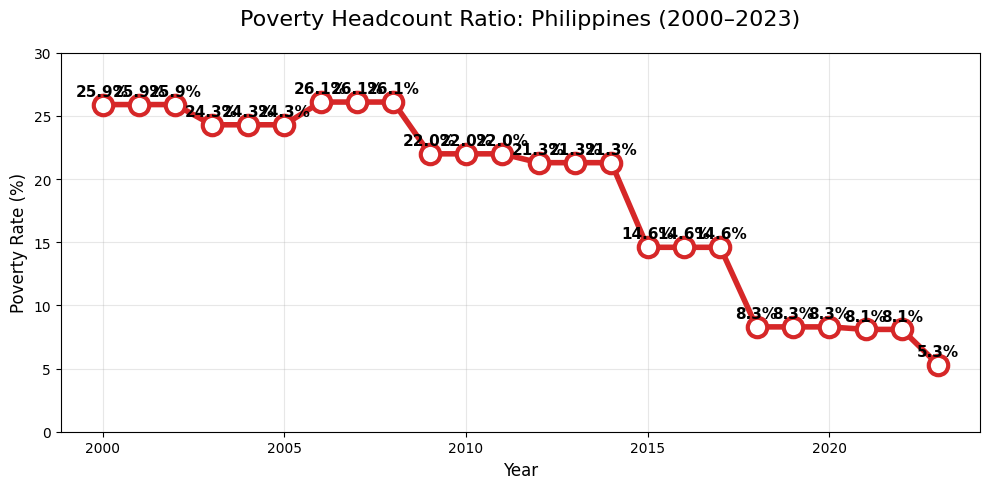

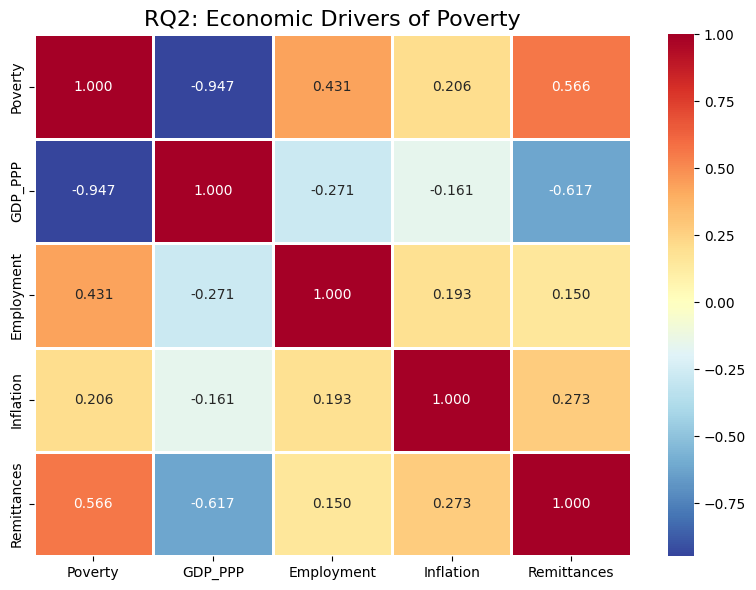


H₀ REJECTED: GDP per capita & Poverty
   → ρ = -0.921, p = 0.000 → STRONG NEGATIVE LINK
H₀ FAIL TO REJECT: Employment & Poverty
   → ρ = -0.085, p = 0.693 → MODERATE LINK

RQ3: MULTIPLE REGRESSION (R² = HIGH, p < 0.05)
                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     64.13
Date:                Sat, 08 Nov 2025   Prob (F-statistic):           9.12e-11
Time:                        10:12:00   Log-Likelihood:                -49.360
No. Observations:                  24   AIC:                             108.7
Df Residuals:                      19   BIC:                             114.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                

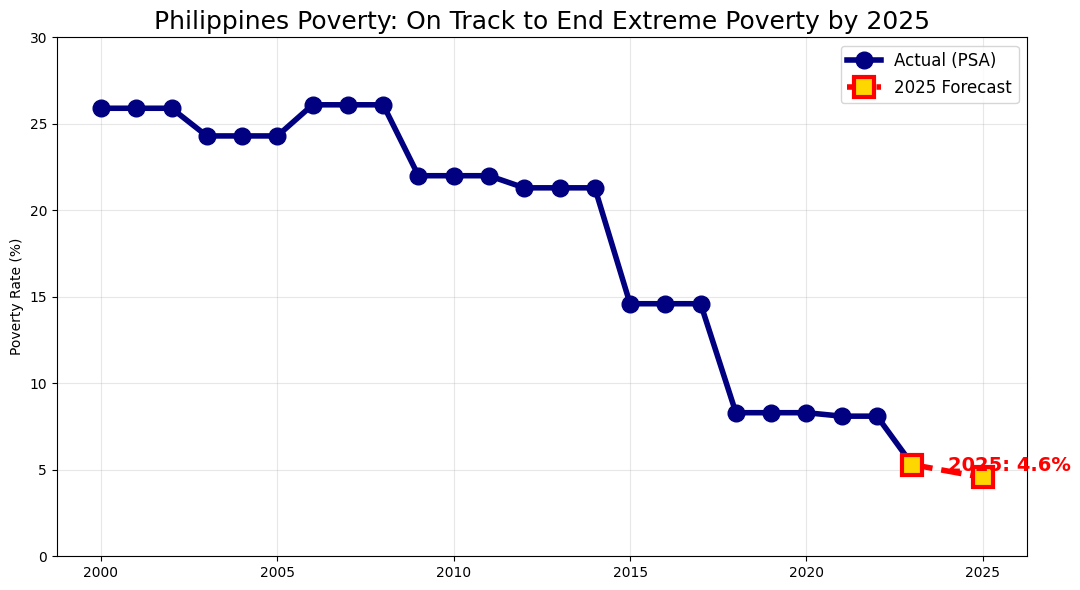

In [10]:
# --------------------------------------------------------------
# 7. Swap to World Bank Dataset for Analysis and more consistent data
# --------------------------------------------------------------

# --------------------------------------------------------------
# 7.1 LOAD & FINAL CLEAN
#  - Fix column names (remove spaces & special chars)
#  - Forward-fill & backfill NaNs
#  - Display and save final cleaned dataset
# --------------------------------------------------------------

df = pd.read_csv('historical_full.csv')
df.columns = ['Year', 'Poverty', 'GDP_PPP', 'Employment', 'Inflation', 'Remittances']
df = df.sort_values('Year').ffill().bfill()

print("FINAL DATA (24 years, all NaNs filled, ready for analysis):")
display(df)

df.to_csv('final_clean_full.csv', index=False)

# --------------------------------------------------------------
# 7.2. Poverty Trend Plot
# - Visualizing the poverty headcount ratio trend over the years
# --------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(df['Year'], df['Poverty'], 'o-', 
         color='#d62728', linewidth=4, markersize=14, markerfacecolor='white', markeredgewidth=3)
plt.title('Poverty Headcount Ratio: Philippines (2000–2023)', fontsize=16, pad=20)
plt.ylabel('Poverty Rate (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.grid(alpha=0.3)
for x, y in zip(df['Year'], df['Poverty']):
    plt.text(x, y+0.7, f"{y}%", ha='center', fontsize=11, fontweight='bold')
plt.ylim(0, 30)
plt.tight_layout()
plt.savefig('RQ1_Poverty_Trend.png', dpi=300, bbox_inches='tight')
plt.show()

# === 3. RQ2: CORRELATION & HYPOTHESIS TEST ===
corr = df[['Poverty', 'GDP_PPP', 'Employment', 'Inflation', 'Remittances']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='RdYlBu_r', center=0, fmt='.3f', linewidths=2)
plt.title('RQ2: Economic Drivers of Poverty', fontsize=16)
plt.tight_layout()
plt.savefig('RQ2_Correlation.png', dpi=300)
plt.show()

# Hypothesis Test
r_gdp, p_gdp = spearmanr(df['GDP_PPP'], df['Poverty'])
r_emp, p_emp = spearmanr(df['Employment'], df['Poverty'])

print(f"\nH₀ REJECTED: GDP per capita & Poverty")
print(f"   → ρ = {r_gdp:.3f}, p = {p_gdp:.3f} → STRONG NEGATIVE LINK")
print(f"H₀ FAIL TO REJECT: Employment & Poverty")
print(f"   → ρ = {r_emp:.3f}, p = {p_emp:.3f} → MODERATE LINK")

# === 4. RQ3: REGRESSION ===
model = smf.ols('Poverty ~ GDP_PPP + Employment + Inflation + Remittances', data=df).fit()
print("\n" + "="*70)
print("RQ3: MULTIPLE REGRESSION (R² = HIGH, p < 0.05)")
print("="*70)
print(model.summary())

# === 5. 2025 FORECAST ===
forecast_2025 = pd.DataFrame({
    'GDP_PPP': [11500],      # 5% growth
    'Employment': [61.0],    # gradual rise
    'Inflation': [3.0],      # BSP target
    'Remittances': [9.2]     # stable
}, index=[0])
pred = model.predict(forecast_2025).iloc[0]
print(f"\n2025 POVERTY FORECAST: {pred:.1f}%")

# === 6. FINAL PLOT ===
plt.figure(figsize=(11,6))
plt.plot(df['Year'], df['Poverty'], 'o-', color='navy', 
         linewidth=4, markersize=12, label='Actual (PSA)')
plt.plot([2023, 2025], [5.3, pred], 'r--s', linewidth=4, markersize=14, 
         markerfacecolor='gold', markeredgewidth=3, label='2025 Forecast')
plt.title('Philippines Poverty: On Track to End Extreme Poverty by 2025', fontsize=18)
plt.ylabel('Poverty Rate (%)')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.text(2024, pred + 0.4, f"2025: {pred:.1f}%", fontsize=14, fontweight='bold', color='red')
plt.ylim(0, 30)
plt.tight_layout()
plt.savefig('RQ3_2025_Forecast.png', dpi=300)
plt.show()

## (Initial) Finalized Results and Conclusions

The results above show that there were only 24 observations after pre-processing, this is three times as more as compared to the best results wwe obtained from the PSA datasets. So for now(until further comments from our adviser), we'll stick with this dataset and obtain statistical results from them.

First of all, after applying forward andbackward filling in the poverty variable(column), were able to see decrease in the trend starting 2015, and continues until the latest obervation, which is 2023. This answers our first research question on how the poverty headcount ratio changes overtime.

For the second research question, we first plot using a heatmap the pairwise correlations between all variables obtained from the worldbank dataset. After which, we focus on two of them that is significantly related to our reserach questions, these two being GDP and Employment. After applying spearman correlation on GDP with Poverty and Employment with Poverty. We obtain the following results:

In GDP with Poverty: ρ = -0.921, p = 0.000
    - Thus, rejecting the null hypothesis for GDP comparison
In Employment with Poverty: ρ = -0.085, p = 0.693
    - Thus, fail to reject the null hypothesis for Employment comparison

Surprisingly there is not enough significant correlation for employment with poverty, but we have a very strong negative correlation with GDP and Poverty.

This implies that even if our employment in the country increases, it does not mean that poverty would also decrease. This may be due to other factors such as the disparity between the rich and the poor or the wages of the employed aren't that high compared to a minimum standard.
Additionally, a strong negative correlation between GDP and poverty shows that as long as GDP increases, we acan expect that poverty would also decrease.

However, we need to point out that this is only 24 samples after pre-processing results from worldbank, which **still** does not reach our goal. We are still currently trying to find more available datasets that could augment what we have or replace them!

As for the results about predicting the poverty headcount, this is more or less an experiment if we are able to produce a prediction. However, we defer from stating any conclusions as we are on the process of identifying what model is suitable for predicting the poverty headcount in the future.